In [ ]:
!pip install labml_nn

In [ ]:
import gdown
import math
import numpy as np
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image

from torchvision import datasets, transforms, utils

from labml_nn.gan.stylegan import Discriminator, Generator, MappingNetwork, GradientPenalty, PathLengthPenalty
import matplotlib.pyplot as plt


In [ ]:


if not os.path.exists("checkpoints"):
  gdown.download_folder("https://drive.google.com/drive/folders/11lPqsECmi8DklOt2yxGrs149M2Nm4bRx", quiet=True)

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dimensionality of $z$ and $w$
d_latent: int = 512
# Height/width of the image
image_size: int = 64
# Number of layers in the mapping network
mapping_network_layers: int = 8
# $\log_2$ of image resolution
log_resolution = int(math.log2(image_size))

In [ ]:

generator = Generator(log_resolution, d_latent).to(device)
# Get number of generator blocks for creating style and noise inputs
n_gen_blocks = generator.n_blocks
# Create mapping network
mapping_network = MappingNetwork(d_latent, mapping_network_layers).to(device)

In [ ]:
mapping_network.load_state_dict(torch.load(os.path.join('checkpoints','mapping_network.pth')))
generator.load_state_dict(torch.load(os.path.join('checkpoints','generator.pth')))

<All keys matched successfully>

In [ ]:
def get_noise( batch_size: int):
        """
        ### Generate noise

        This generates noise for each [generator block](index.html#generator_block)
        """
        # List to store noise
        noise = []
        # Noise resolution starts from $4$
        resolution = 4

        # Generate noise for each generator block
        for i in range(n_gen_blocks):
            # The first block has only one $3 \times 3$ convolution
            if i == 0:
                n1 = None
            # Generate noise to add after the first convolution layer
            else:
                n1 = torch.randn(batch_size, 1, resolution, resolution, device=device)
            # Generate noise to add after the second convolution layer
            n2 = torch.randn(batch_size, 1, resolution, resolution, device=device)

            # Add noise tensors to the list
            noise.append((n1, n2))

            # Next block has $2 \times$ resolution
            resolution *= 2

        # Return noise tensors
        return noise

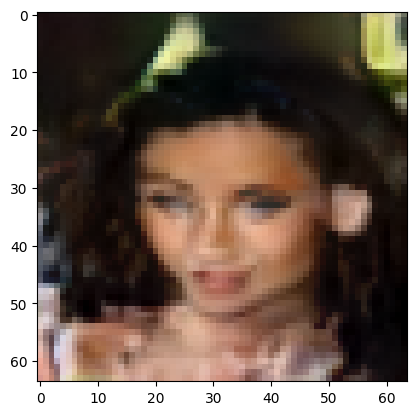

In [13]:
batch_size=1
# Sample $z$ and $z$
z = torch.randn(batch_size, d_latent).to(device)
# Get $w$ and $w$
w = mapping_network(z)
# Expand $w$ for the generator blocks
w = w[None, :, :].expand(n_gen_blocks, -1, -1)

# Get noise
noise = get_noise(batch_size)

# Generate images
images = generator(w, noise)

plt.imshow(images.permute(0,2,3,1).clip(0,1).detach()[0].cpu().numpy())